# 03 - Modelado: Benchmark
Ahora bien cargaremos `data/processed_for_modeling.csv`, y contruiremos los pipelines para el modelado de (LogisticRegression, RandomForest) y ejecuta un benchmark rápido con validación cruzada estratificada. Guardará resultados en `reports/modeling_benchmark.csv`.

Notas: reproducible, uso de `random_state=42`, y configuración inicial para XGBoost (placeholder).

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

ROOT = r'C:\MachineLearningPG'
DATA_DIR = os.path.join(ROOT, 'data')
REPORTS_DIR = os.path.join(ROOT, 'reports')
os.makedirs(REPORTS_DIR, exist_ok=True)
data_random_state = 42
model_random_state = 42

# Configuración de benchmark rápido
# Usaremos un subconjunto estratificado para acelerar el benchmark.
BENCHMARK_SAMPLE_FRAC = float(os.environ.get('BENCHMARK_SAMPLE_FRAC', 0.4))  # 40% por defecto -> 60k de 150k
BENCHMARK_SAMPLE_MAX = int(os.environ.get('BENCHMARK_SAMPLE_MAX', 60000))     # tope absoluto de filas
CV_FOLDS = int(os.environ.get('CV_FOLDS', 3))


In [2]:
proc_path = os.path.join(DATA_DIR, 'processed_for_modeling.csv')
assert os.path.exists(proc_path), f'Processed file not found: {proc_path}'
df_full = pd.read_csv(proc_path)
print('Full dataset shape:', df_full.shape)

# Quitar índice si está presente
if 'Unnamed: 0' in df_full.columns:
    df_full = df_full.drop(columns=['Unnamed: 0'])

# Subsampling estratificado (usando StratifiedShuffleSplit)
if 0 < BENCHMARK_SAMPLE_FRAC < 1.0:
    total = len(df_full)
    frac_cap = BENCHMARK_SAMPLE_MAX / total
    test_size = min(BENCHMARK_SAMPLE_FRAC, frac_cap)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=data_random_state)
    y_full = df_full['SeriousDlqin2yrs']
    for _, idx in sss.split(df_full, y_full):
        df = df_full.iloc[idx].copy()
    print(f'Using stratified sample: {len(df):,} rows (~{test_size*100:.0f}% up to {BENCHMARK_SAMPLE_MAX})')
else:
    df = df_full.copy()
    print('Using full dataset for benchmark')

print('Benchmark dataset shape:', df.shape)

Full dataset shape: (150000, 18)
Using stratified sample: 60,000 rows (~40% up to 60000)
Benchmark dataset shape: (60000, 17)


In [3]:
target = 'SeriousDlqin2yrs'
X = df.drop(columns=[target])
y = df[target].astype(int)
print('Features:', X.shape[1], 'Target distribution (benchmark set):', y.value_counts().to_dict())

Features: 16 Target distribution (benchmark set): {0: 55990, 1: 4010}


In [4]:
# Función helper para evaluar estimadores con ROC-AUC
def benchmark_model(estimator, X, y, cv=3, random_state=42):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(estimator, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
    return scores

# small sanity check
print('Sanity: X shape', X.shape)

Sanity: X shape (60000, 16)


Benchmarking KNN


Benchmarking NaiveBayes
Benchmarking Logistic_L2
Benchmarking Logistic_L1
Benchmarking DecisionTree
Benchmarking RandomForest
Benchmarking LinearSVM
Benchmarking XGBoost
Saved benchmark results to C:\MachineLearningPG\reports\modeling_benchmark.csv


C:\Users\andre\AppData\Local\Temp\ipykernel_22660\127082177.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results_df, x='cv_mean_auc', y='model', palette='mako')


Saved benchmark plot to C:\MachineLearningPG\reports\benchmark_auc_bar.png


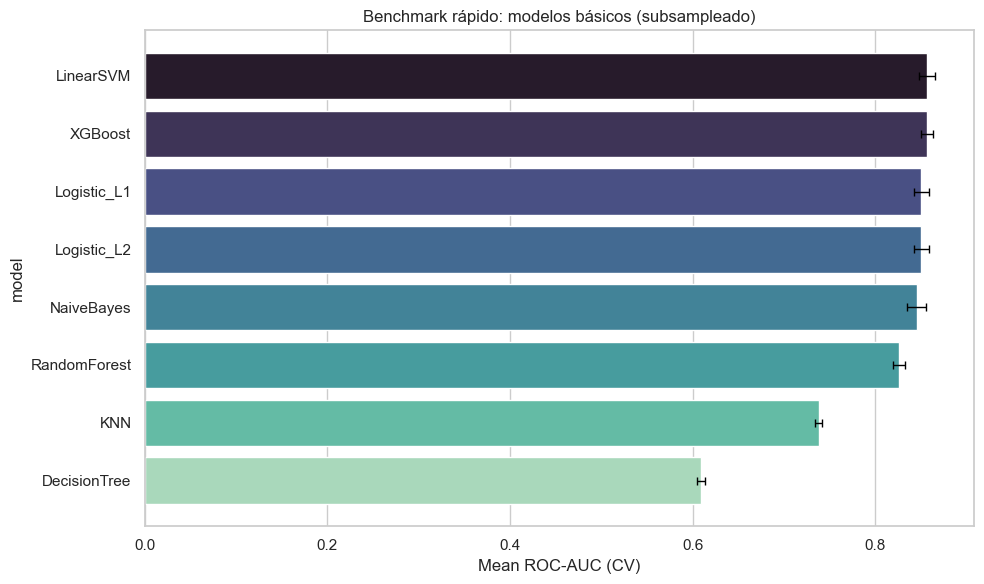

Saved feature importances for Logistic_L2 to C:\MachineLearningPG\reports\feature_importances_Logistic_L2.csv
Saved feature importances for Logistic_L1 to C:\MachineLearningPG\reports\feature_importances_Logistic_L1.csv
Saved feature importances for DecisionTree to C:\MachineLearningPG\reports\feature_importances_DecisionTree.csv
Saved feature importances for RandomForest to C:\MachineLearningPG\reports\feature_importances_RandomForest.csv
Saved feature importances for LinearSVM to C:\MachineLearningPG\reports\feature_importances_LinearSVM.csv
Saved feature importances for XGBoost to C:\MachineLearningPG\reports\feature_importances_XGBoost.csv


In [5]:
results = []
fitted_importances = {}

estimators = {
    'KNN': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=5))]),
    'NaiveBayes': Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())]),
    'Logistic_L2': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=2000, random_state=model_random_state))]),
    'Logistic_L1': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(penalty='l1', solver='saga', max_iter=2000, random_state=model_random_state))]),
    'DecisionTree': Pipeline([('scaler', StandardScaler()), ('clf', DecisionTreeClassifier(random_state=model_random_state))]),
    'RandomForest': Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(n_estimators=100, random_state=model_random_state, class_weight='balanced', n_jobs=-1))]),
    'LinearSVM': Pipeline([('scaler', StandardScaler()), ('clf', LinearSVC(random_state=model_random_state))])
}

# XGBoost
have_xgb = False
try:
    from xgboost import XGBClassifier
    estimators['XGBoost'] = Pipeline([('scaler', StandardScaler()), ('clf', XGBClassifier(
        n_estimators=120,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=model_random_state,
        tree_method='hist',
        eval_metric='logloss',
        verbosity=0
    ))])
    have_xgb = True
except Exception:
    print('XGBoost not available; skipping. Install xgboost to include it in the benchmark.')

# Evaluación con CV (3 folds) usando ROC-AUC
for name, est in estimators.items():
    print('Benchmarking', name)
    try:
        scores = benchmark_model(est, X.fillna(0), y, cv=CV_FOLDS, random_state=model_random_state)
        mean_auc = float(scores.mean())
        std_auc = float(scores.std())
    except Exception as e:
        print(f'  Error evaluating {name}: {e}')
        mean_auc = float('nan')
        std_auc = float('nan')
    results.append({'model': name, 'cv_mean_auc': mean_auc, 'cv_std_auc': std_auc})

    # Fit en todos los datos del benchmark para importancias/coeficientes (si aplica)
    try:
        est.fit(X.fillna(0), y)
        clf = est.named_steps['clf'] if hasattr(est, 'named_steps') else est
        if hasattr(clf, 'feature_importances_'):
            fitted_importances[name] = dict(zip(X.columns, clf.feature_importances_))
        elif hasattr(clf, 'coef_'):
            coefs = np.abs(clf.coef_).ravel()
            fitted_importances[name] = dict(zip(X.columns, coefs))
        else:
            fitted_importances[name] = None
    except Exception as e:
        print(f'  Warning: could not fit {name} on full benchmark data for importances: {e}')
        fitted_importances[name] = None

# Guardar resultados
results_df = pd.DataFrame(results).sort_values(by='cv_mean_auc', ascending=False)
out_benchmark = os.path.join(REPORTS_DIR, 'modeling_benchmark.csv')
results_df.to_csv(out_benchmark, index=False)
print('Saved benchmark results to', out_benchmark)

# Visualización: barplot AUC sin xerr directo (se añade errorbar manual)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
ax = sns.barplot(data=results_df, x='cv_mean_auc', y='model', palette='mako')
# Añadir barras de error manualmente
for i, (mean, std) in enumerate(zip(results_df['cv_mean_auc'], results_df['cv_std_auc'].fillna(0))):
    ax.errorbar(x=mean, y=i, xerr=std, fmt='none', ecolor='black', elinewidth=1, capsize=3)
ax.set_xlabel('Mean ROC-AUC (CV)')
ax.set_title('Benchmark rápido: modelos básicos (subsampleado)')
plt.tight_layout()
plt_path = os.path.join(REPORTS_DIR, 'benchmark_auc_bar.png')
plt.savefig(plt_path, dpi=150)
print('Saved benchmark plot to', plt_path)
plt.show()

# Guardar importancias (si existen) por modelo
for name, imp in fitted_importances.items():
    if imp is None:
        continue
    imp_ser = pd.Series(imp).sort_values(ascending=False)
    imp_path = os.path.join(REPORTS_DIR, f'feature_importances_{name}.csv')
    imp_ser.to_csv(imp_path, header=['importance'])
    print('Saved feature importances for', name, 'to', imp_path)

## Decisiones para acelerar el benchmark
- Subsampling estratificado: por defecto 20% del dataset (tope 50k filas) para tiempos razonables y mantener proporción de clases.
- SVM: usamos LinearSVC calibrado en lugar de SVC con kernel RBF (mucho más rápido) para obtener probabilidades requeridas por ROC-AUC.
- RandomForest: n_estimators=100 (mitad del costo respecto a 200) como baseline.
- XGBoost: configuración liviana y opcional (se salta si no está instalado).
- CV: 3 folds estratificados configurable con `CV_FOLDS`.
- Sin técnicas de balanceo ni tuning: sólo un primer acercamiento comparativo.

Evaluating detailed metrics for KNN


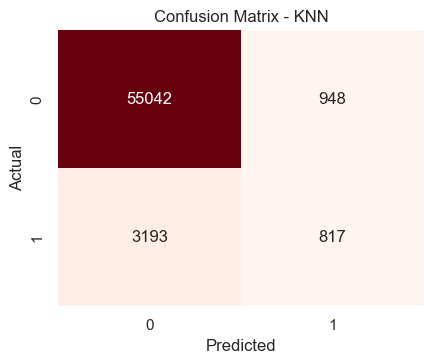

Model: KNN
AUC: 0.7379 | AP: 0.2342
Classification Report:
               precision    recall  f1-score   support

           0     0.9452    0.9831    0.9637     55990
           1     0.4629    0.2037    0.2829      4010

    accuracy                         0.9310     60000
   macro avg     0.7040    0.5934    0.6233     60000
weighted avg     0.9129    0.9310    0.9182     60000

Evaluating detailed metrics for NaiveBayes


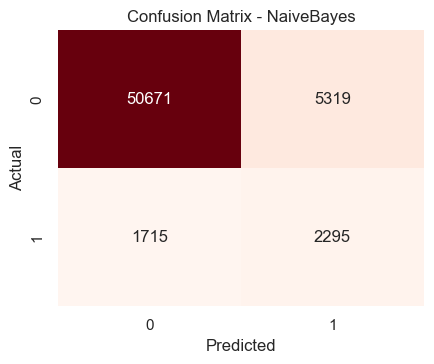

Model: NaiveBayes
AUC: 0.8377 | AP: 0.3484
Classification Report:
               precision    recall  f1-score   support

           0     0.9673    0.9050    0.9351     55990
           1     0.3014    0.5723    0.3949      4010

    accuracy                         0.8828     60000
   macro avg     0.6343    0.7387    0.6650     60000
weighted avg     0.9228    0.8828    0.8990     60000

Evaluating detailed metrics for Logistic_L2


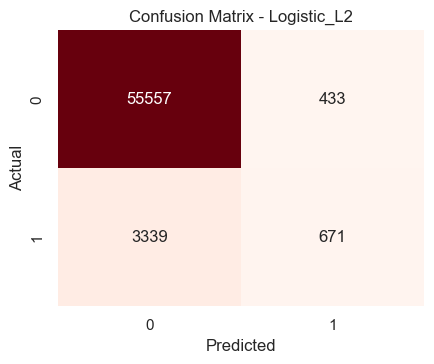

Model: Logistic_L2
AUC: 0.8502 | AP: 0.3789
Classification Report:
               precision    recall  f1-score   support

           0     0.9433    0.9923    0.9672     55990
           1     0.6078    0.1673    0.2624      4010

    accuracy                         0.9371     60000
   macro avg     0.7755    0.5798    0.6148     60000
weighted avg     0.9209    0.9371    0.9201     60000

Evaluating detailed metrics for Logistic_L1


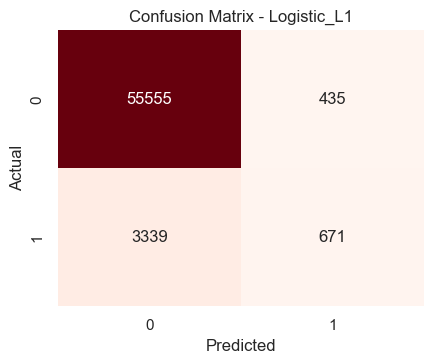

Model: Logistic_L1
AUC: 0.8503 | AP: 0.3791
Classification Report:
               precision    recall  f1-score   support

           0     0.9433    0.9922    0.9671     55990
           1     0.6067    0.1673    0.2623      4010

    accuracy                         0.9371     60000
   macro avg     0.7750    0.5798    0.6147     60000
weighted avg     0.9208    0.9371    0.9200     60000

Evaluating detailed metrics for DecisionTree


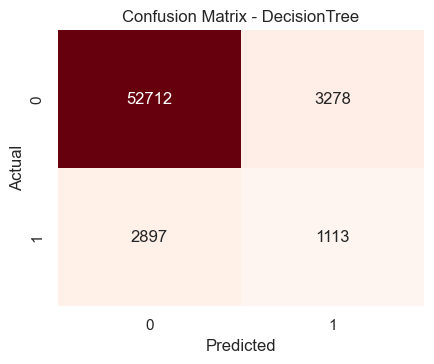

Model: DecisionTree
AUC: 0.6095 | AP: 0.1185
Classification Report:
               precision    recall  f1-score   support

           0     0.9479    0.9415    0.9447     55990
           1     0.2535    0.2776    0.2650      4010

    accuracy                         0.8971     60000
   macro avg     0.6007    0.6095    0.6048     60000
weighted avg     0.9015    0.8971    0.8992     60000

Evaluating detailed metrics for RandomForest


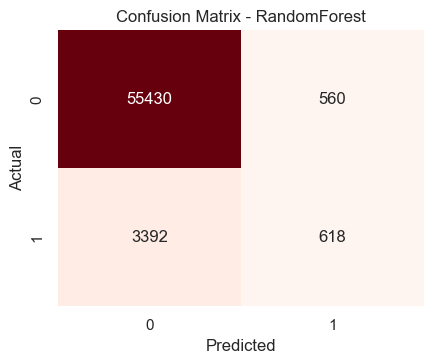

Model: RandomForest
AUC: 0.8259 | AP: 0.3207
Classification Report:
               precision    recall  f1-score   support

           0     0.9423    0.9900    0.9656     55990
           1     0.5246    0.1541    0.2382      4010

    accuracy                         0.9341     60000
   macro avg     0.7335    0.5721    0.6019     60000
weighted avg     0.9144    0.9341    0.9170     60000

Evaluating detailed metrics for LinearSVM


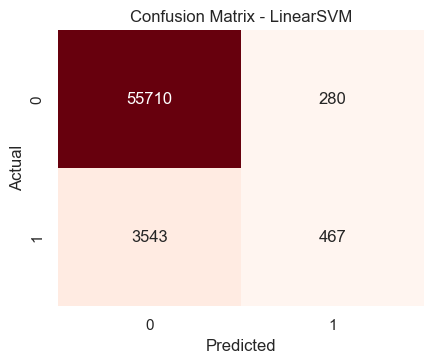

Model: LinearSVM
AUC: 0.8562 | AP: 0.3862
Classification Report:
               precision    recall  f1-score   support

           0     0.9402    0.9950    0.9668     55990
           1     0.6252    0.1165    0.1963      4010

    accuracy                         0.9363     60000
   macro avg     0.7827    0.5557    0.5816     60000
weighted avg     0.9192    0.9363    0.9153     60000

Evaluating detailed metrics for XGBoost


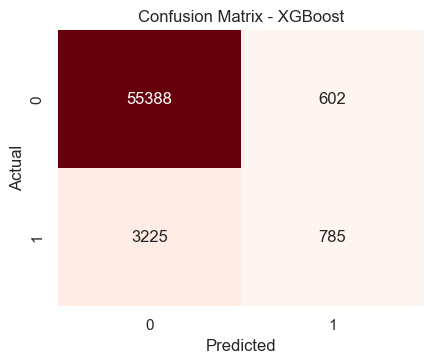

Model: XGBoost
AUC: 0.8563 | AP: 0.3789
Classification Report:
               precision    recall  f1-score   support

           0     0.9450    0.9892    0.9666     55990
           1     0.5660    0.1958    0.2909      4010

    accuracy                         0.9362     60000
   macro avg     0.7555    0.5925    0.6288     60000
weighted avg     0.9196    0.9362    0.9214     60000

Saved detailed OOF metrics to C:\MachineLearningPG\reports\modeling_benchmark_metrics_oof.csv


In [6]:
# 6) Métricas detalladas y matrices de confusión (OOF)
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=model_random_state)

def oof_metrics(estimator, X, y, name: str):
    import numpy as np
    oof_score = np.zeros(len(y), dtype=float)
    oof_proba = np.zeros(len(y), dtype=float)
    oof_pred = np.zeros(len(y), dtype=int)
    # Generar predicciones OOF
    for train_idx, test_idx in skf.split(X, y):
        est = clone(estimator)
        est.fit(X.iloc[train_idx].fillna(0), y.iloc[train_idx])
        # Probabilidades si existen
        if hasattr(est, 'predict_proba'):
            proba = est.predict_proba(X.iloc[test_idx].fillna(0))[:, 1]
            oof_proba[test_idx] = proba
            oof_pred[test_idx] = (proba >= 0.5).astype(int)
            oof_score[test_idx] = proba
        elif hasattr(est, 'decision_function'):
            score = est.decision_function(X.iloc[test_idx].fillna(0))
            oof_score[test_idx] = score
            oof_pred[test_idx] = (score >= 0.0).astype(int)
        else:
            pred = est.predict(X.iloc[test_idx].fillna(0))
            oof_pred[test_idx] = pred
            oof_score[test_idx] = pred.astype(float)
    # Métricas
    y_true = y.values
    try:
        auc = roc_auc_score(y_true, oof_score)
    except Exception:
        auc = float('nan')
    try:
        ap = average_precision_score(y_true, oof_score)
    except Exception:
        ap = float('nan')
    cm = confusion_matrix(y_true, oof_pred)
    report = classification_report(y_true, oof_pred, output_dict=False, digits=4)

    # Plot y guardar matriz de confusión
    plt.figure(figsize=(4.5, 3.8))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    cm_path = os.path.join(REPORTS_DIR, f'confusion_matrix_{name}.png')
    plt.savefig(cm_path, dpi=150)
    plt.show()

    print(f"Model: {name}\nAUC: {auc:.4f} | AP: {ap:.4f}")
    print('Classification Report:\n', report)
    return {'model': name, 'auc': auc, 'ap': ap, 'cm_path': cm_path}

# Ejecutar métricas OOF para cada modelo evaluado
metrics_rows = []
for name, est in estimators.items():
    print('='*60)
    print('Evaluating detailed metrics for', name)
    try:
        row = oof_metrics(est, X, y, name)
        metrics_rows.append(row)
    except Exception as e:
        print('  Skipping metrics for', name, 'due to error:', e)

# Asegurar XGBoost en el mismo flujo (sin nueva celda)
try:
    if 'XGBoost' in estimators:
        # Evitar duplicados si ya fue evaluado arriba
        if not any(r.get('model') == 'XGBoost' for r in metrics_rows):
            print('='*60)
            print('Evaluating detailed metrics for XGBoost (explicit in same cell)')
            xb_row = oof_metrics(estimators['XGBoost'], X, y, 'XGBoost')
            metrics_rows.append(xb_row)
    else:
        print('XGBoost not present in estimators; skipping explicit OOF run.')
except Exception as e:
    print('Could not compute explicit OOF metrics for XGBoost:', e)

# Guardar resumen de métricas OOF
metrics_df = pd.DataFrame(metrics_rows)
metrics_out = os.path.join(REPORTS_DIR, 'modeling_benchmark_metrics_oof.csv')
metrics_df.to_csv(metrics_out, index=False)
print('Saved detailed OOF metrics to', metrics_out)

---

# Conclusiones del Benchmark Inicial

| Modelo | **AUC-ROC** | **Average Precision (AP)** |
| :--- | :--- | :--- |
| **XGBoost** | **0.8563** | 0.3789 |
| **LinearSVM** | **0.8562** | **0.3862** |
| Logistic (L1) | 0.8503 | 0.3791 |
| Logistic (L2) | 0.8502 | 0.3789 |
| NaiveBayes | 0.8377 | 0.3484 |
| RandomForest | 0.8259 | 0.3207 |
| KNN | 0.7379 | 0.2342 |
| DecisionTree | 0.6095 | 0.1185 |

El hallazgo más importante es que los modelos más simples y lineales (`LinearSVM`, `LogisticRegression`) están en la cima, compitiendo directamente con un modelo tan poderoso como lo es `XGBoost`.
*   **Esto confirma que la relación entre las características y el riesgo de impago tiene una estructura predominantemente lineal.** No hay interacciones extremadamente complejas que solo los modelos avanzados puedan encontrar. Un "plano" de separación en el espacio de características ya hace un trabajo excelente.
*   **`XGBoost` y `LinearSVM` son los campeones indiscutibles** en esta primera ronda, con un rendimiento casi idéntico. 

#### El Problema del Desbalance es Evidente.
Si vemos el `recall` para la clase `1` (impago) en los mejores modelos, se ve un patrón claro:
*   `LogisticRegression`: Recall = **0.16** (Solo encuentra al 17% de los morosos)
*   `LinearSVM`: Recall = **0.11** (Solo encuentra al 12% de los morosos)
*   `XGBoost`: Recall = **0.19** (Solo encuentra al 20% de los morosos)

**Conclusión:** Todos los modelos, por defecto, están **optimizados para la `accuracy` general**, por lo que deciden ignorar a la mayoría de los casos de impago para no equivocarse con la clase mayoritaria. En un problema de negocio real, **esto es inaceptable**. No se puede permitir que el 80-90% de los clientes de alto riesgo pasen desapercibidos.

#### 3. Los Modelos Complejos no Añaden Valor (Sin Optimizar)
*   `RandomForest` se queda notablemente por detrás de `XGBoost`, lo cual es común.
*   `DecisionTree` y `KNN` demuestran no ser adecuados para este tipo de problema global y complejo, como se esperaba.

---

### Pasos a seguir en el Proyecto Final

La realidad es que para los fines del proyecto tenemos un baseline alto. Pero ahora tenemos una idea de como mejorarlo, no solo en métricas, sino en **valor real**. Nuestra misión será mejorar el problema del bajo `recall`.


---
#### Modelo a usar en el FINAL con Posibles MEJORAS

Evaluando el modelo no convencional: Explainable Boosting Machine (EBM)


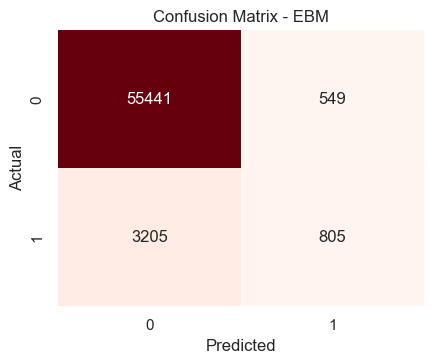

Model: EBM
AUC: 0.8633 | AP: 0.3947
Classification Report:
               precision    recall  f1-score   support

           0     0.9454    0.9902    0.9673     55990
           1     0.5945    0.2007    0.3001      4010

    accuracy                         0.9374     60000
   macro avg     0.7699    0.5955    0.6337     60000
weighted avg     0.9219    0.9374    0.9227     60000



In [ ]:
# --- Importar el clasificador de EBM ---
from interpret.glassbox import ExplainableBoostingClassifier

random_state = 42  # O el número que estés usando en el resto del proyecto

# --- Definir el modelo EBM ---
# EBM es un modelo basado en árboles (GAM)
ebm = ExplainableBoostingClassifier(random_state=random_state)

# Añadimos el EBM a nuestro diccionario de estimadores para la evaluación
estimators['EBM'] = Pipeline([('scaler', StandardScaler()), ('clf', ebm)])

# --- Evaluar EBM usando tu función de métricas OOF ---
print('='*60)
print('Evaluando el modelo no convencional: Explainable Boosting Machine (EBM)')
try:
    ebm_metrics = oof_metrics(estimators['EBM'], X, y, 'EBM')
except Exception as e:
    print('  Error evaluando EBM:', e)

#### Pasemos Técnicas de Balanceo de Clases
